In [2]:
import chardet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics, preprocessing, datasets
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix
#import tensorflow as tf
#from tensorflow.keras import Sequential, Model
#from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Input, BatchNormalization, Dropout, Activation, GlobalAveragePooling1D
import random
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
import os, shutil, time
%matplotlib inline

In [42]:
df101=pd.read_csv(r'./101年-臺北市A1及A2類交通事故明細.csv.csv',encoding='big5')
df102=pd.read_csv(r'./102年-臺北市A1及A2類交通事故明細.csv.csv',encoding='big5')
df103=pd.read_csv(r'./103年-臺北市A1及A2類交通事故明細.csv.csv',encoding='big5')
df104=pd.read_csv(r'./104年-臺北市A1及A2類交通事故明細.csv.csv',encoding='utf-8')
df105=pd.read_csv(r'./105年-臺北市A1及A2類交通事故明細.csv.csv',encoding='big5')
df106=pd.read_csv(r'./106年-臺北市A1及A2類交通事故明細.csv.csv',encoding='big5')
df107=pd.read_csv(r'./107年-臺北市A1及A2類交通事故明細.csv.csv',encoding='big5')
df108=pd.read_csv(r'./108年-臺北市A1及A2類交通事故明細.csv.csv',encoding='big5')
df109=pd.read_csv(r'./109年-臺北市A1及A2類交通事故明細.csv.csv',encoding='utf-8')
df104.rename(columns={'天候':'4天候','速限':'7速限','道路型態':'8道路型態','事故位置':'9事故位置'},inplace=True)
df105.rename(columns={'天候':'4天候','速限':'7速限','道路型態':'8道路型態','事故位置':'9事故位置'},inplace=True)
df107.rename(columns={'天候':'4天候','速限':'7速限','道路型態':'8道路型態','事故位置':'9事故位置'},inplace=True)
df109.rename(columns={'天候':'4天候','速限':'7速限','道路型態':'8道路型態','事故位置':'9事故位置'},inplace=True)
result = pd.concat([df101,df102,df103,df104,df105,df106,df107,df108,df109],axis=0)
age=result.query('年齡>100').index.tolist()
result = result.drop(age)
result.index = range(len(result))

In [43]:
time = []
for i in range(len(result)):
    if result['發生時'][i]>=0 and result['發生時'][i]<=3:
        time.append(1)
    elif result['發生時'][i]>=4 and result['發生時'][i]<=6:
        time.append(2)
    elif result['發生時'][i]>=7 and result['發生時'][i]<=8:
        time.append(3)
    elif result['發生時'][i]>=9 and result['發生時'][i]<=10:
        time.append(4)
    elif result['發生時'][i]>=11 and result['發生時'][i]<=12:
        time.append(5)
    elif result['發生時'][i]>=13 and result['發生時'][i]<=16:
        time.append(6)
    elif result['發生時'][i]>=17 and result['發生時'][i]<=19:
        time.append(7)
    else:
        time.append(8)
time = pd.DataFrame(time,columns=['time'])
result = pd.concat([result,time],axis=1)

In [97]:
corrcoef = result[["4天候","7速限","8道路型態","9事故位置","time","車種","受傷人數","死亡人數"]]
corrcoef.columns = ["Weather","SpeedLimit","RoadPattern","AccidentLocation","time","car","injured","death"]
corrcoef = corrcoef.dropna()
corrcoef.isnull().any()
corrcoef.index = range(len(corrcoef))

In [98]:
SpeedLimit=corrcoef.query('SpeedLimit>110').index.tolist()
corrcoef = corrcoef.drop(SpeedLimit)
corrcoef.index = range(len(corrcoef)) #重新建立索引值，不然中間會跳號，因為剛drop完

In [99]:
corrcoef.loc[corrcoef.death>=1, 'death'] = 1 #死亡人數1以上都變成1 -> 1=有人死,0=沒人死

In [100]:
car = corrcoef['car'].value_counts()
list_car = car.keys().tolist()
for c in list_car:
    ind = list_car.index(c)
    corrcoef.loc[corrcoef.car==c, 'car'] = ind
corrcoef["car"] = corrcoef["car"].astype(int)
corrcoef

,Weather,SpeedLimit,RoadPattern,AccidentLocation,time,car,injured,death
0,8.0,0.0,4.0,2.0,4,1,1,0
1,8.0,0.0,4.0,2.0,4,0,1,0
2,8.0,50.0,4.0,1.0,5,0,2,0
3,8.0,50.0,4.0,1.0,5,0,2,0
4,7.0,50.0,4.0,1.0,8,1,1,0
...,...,...,...,...,...,...,...,...
421576,8.0,30.0,4.0,1.0,8,0,3,0
421577,8.0,30.0,4.0,1.0,8,2,3,0
421578,8.0,30.0,4.0,1.0,8,1,3,0
421579,8.0,50.0,14.0,8.0,8,5,1,0


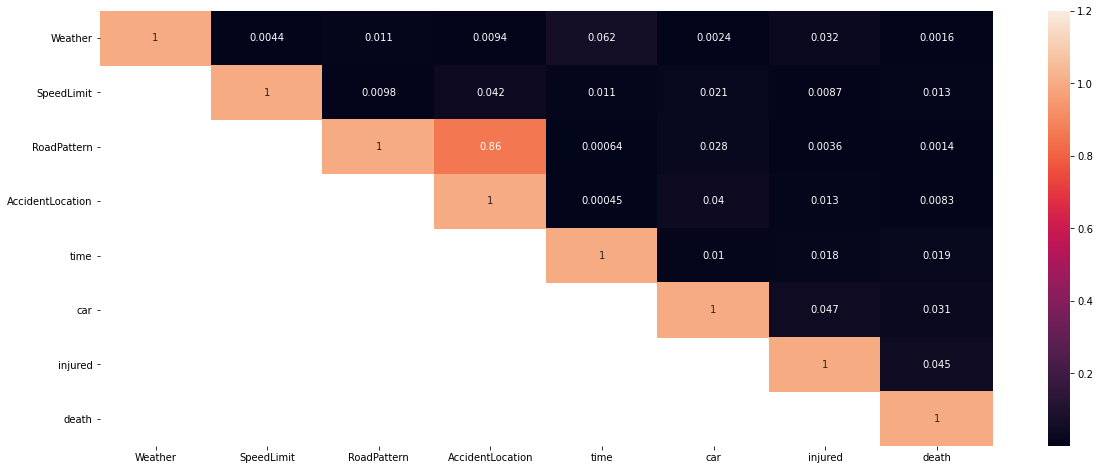

In [101]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(20,8))
corrcoef1_new = abs(corrcoef.corr())
mask = np.array(corrcoef1_new)
mask[np.triu_indices_from(mask)] = False 
sns.heatmap(corrcoef1_new, mask=mask, vmax=1.2, annot=True, ax=ax)
plt.show();

In [102]:
dead=corrcoef['death']
corrcoef=corrcoef.drop(['death'], axis=1)
#X,y兩種方式都可以取到陣列
X = np.array(corrcoef[['car','injured']])
y = dead.values

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [104]:
modelm=MultinomialNB()
modelm.fit(X_train,y_train)
modelm.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [105]:
modelm.predict_proba(X_test) #沒人死的機率,有人死的機率

array([[9.98172386e-01, 1.82761352e-03],
       [9.98172386e-01, 1.82761352e-03],
       [9.98244063e-01, 1.75593716e-03],
       ...,
       [9.99112863e-01, 8.87136842e-04],
       [9.97429550e-01, 2.57044980e-03],
       [9.98172386e-01, 1.82761352e-03]])

In [106]:
modelm.score(X_test,y_test)

0.9925202609211307

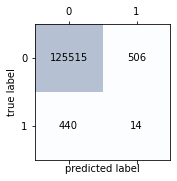

In [107]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
confmat = confusion_matrix(y_true=y_test, y_pred=modelm.predict(X_test))
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.show()